<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#▎Шаг-1:-Импорт-библиотек-и-загрузка-данных" data-toc-modified-id="▎Шаг-1:-Импорт-библиотек-и-загрузка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>▎Шаг 1: Импорт библиотек и загрузка данных</a></span></li><li><span><a href="#▎Шаг-2:-Предобработка-данных" data-toc-modified-id="▎Шаг-2:-Предобработка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>▎Шаг 2: Предобработка данных</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Шаг-3:-Преобразование-текста-и-построение-модели" data-toc-modified-id="Шаг-3:-Преобразование-текста-и-построение-модели-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Шаг 3: Преобразование текста и построение модели</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### ▎Шаг 1: Импорт библиотек и загрузка данных

Для начала загрузим необходимые библиотеки и набор данных:


In [1]:
# Установка библиотек (если не установлены)
!pip install Pillow==9.3.0
!pip install wordcloud==1.8.2.2

import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from nltk import pos_tag
from wordcloud import WordCloud
from collections import Counter

     |████████████████████████████████| 3.3 MB 1.1 MB/s eta 0:00:01
  Attempting uninstall: Pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0
     |████████████████████████████████| 458 kB 1.0 MB/s eta 0:00:01


In [2]:
# Загрузка данных
data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

# Пример первых строк данных
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


### ▎Шаг 2: Предобработка данных

1. Удалим символы, оставив только текст.
2. Преобразуем текст к нижнему регистру.
3. Уберем стоп-слова.

**Очищаем текст**

In [3]:
# Загрузка данных для NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

# Инициализация лемматизатора и стоп-слов
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Функция для преобразования POS-тега в формат WordNet
def get_wordnet_pos(nltk_tag):
    if nltk_tag.startswith('J'):  # Прилагательные
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):  # Глаголы
        return wordnet.VERB
    elif nltk_tag.startswith('N'):  # Существительные
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):  # Наречия
        return wordnet.ADV
    else:
        return None

# Функция для предобработки текста
def preprocess_text(text):
    # Преобразуем текст в нижний регистр и очищаем от неалфавитных символов
    text_cleaned = re.sub(r'[^a-z\s]', '', text.lower())
    
    # Токенизация расколов строки на слова
    words = word_tokenize(text_cleaned)
    
    # Удаляем стоп-слова
    words = [word for word in words if word not in stop_words]
    
    # Определяем POS-теги
    pos_tags = pos_tag(words)
    
    # Лемматизация слов с учетом частей речи
    lemmatized_words = []
    for word, tag in pos_tags:
        pos = get_wordnet_pos(tag) or wordnet.NOUN  # По умолчанию считаем словом существительное
        lemmatized_words.append(lemmatizer.lemmatize(word, pos))
    
    return ' '.join(lemmatized_words)

data['cleaned_text'] = data['text'].apply(preprocess_text)
data[['text', 'cleaned_text']]

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,text,cleaned_text
0,Explanation\nWhy the edits made under my usern...,explanation edits make username hardcore metal...
1,D'aww! He matches this background colour I'm s...,daww match background colour im seemingly stuc...
2,"Hey man, I'm really not trying to edit war. It...",hey man im really try edit war guy constantly ...
3,"""\nMore\nI can't make any real suggestions on ...",cant make real suggestion improvement wonder s...
4,"You, sir, are my hero. Any chance you remember...",sir hero chance remember page thats
...,...,...
159446,""":::::And for the second time of asking, when ...",second time ask view completely contradict cov...
159447,You should be ashamed of yourself \n\nThat is ...,ashamed horrible thing put talk page
159448,"Spitzer \n\nUmm, theres no actual article for ...",spitzer umm there actual article prostitution ...
159449,And it looks like it was actually you who put ...,look like actually put speedy first version de...


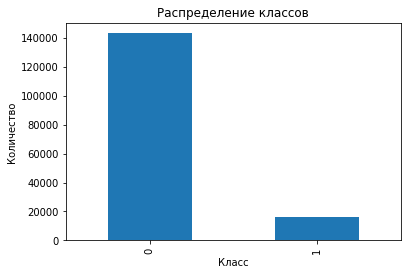

In [4]:
# 1. Проверка на дисбаланс классов
#- Посчитайте распределение классов в целевой переменной (target).
#- Постройте визуализацию (например, барплот или круговую диаграмму) для наглядного представления.

# Распределение классов
data['toxic'].value_counts().plot(kind='bar')
plt.title('Распределение классов')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.show()

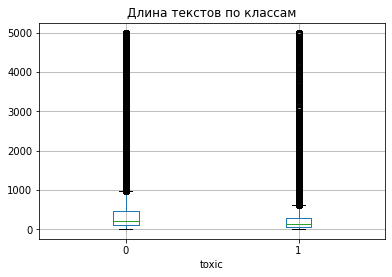

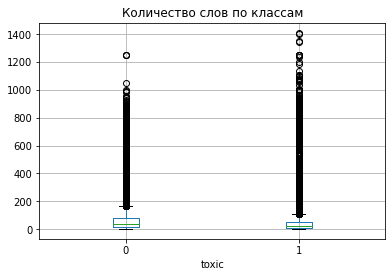

In [5]:
# 2. Длина текстов и их разбиение по таргету
# - Добавьте признаки, например, длина текста, количество слов.
# - Исследуйте их распределение по классам.

data['text_length'] = data['text'].apply(len)
data['word_count'] = data['text'].apply(lambda x: len(x.split()))

# Графики
data.boxplot(column='text_length', by='toxic')
plt.title('Длина текстов по классам')
plt.suptitle('')
plt.show()

data.boxplot(column='word_count', by='toxic')
plt.title('Количество слов по классам')
plt.suptitle('')
plt.show()

In [6]:
# 3. Оценка сентиментов
#Используйте библиотеку SentimentIntensityAnalyzer из nltk:

nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()
data['sentiment'] = data['text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Корреляция сентимента с таргетом
correlation = data[['sentiment', 'toxic']].corr()
print(correlation)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...


           sentiment     toxic
sentiment   1.000000 -0.294936
toxic      -0.294936  1.000000


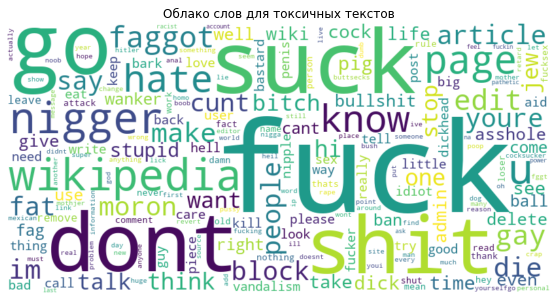

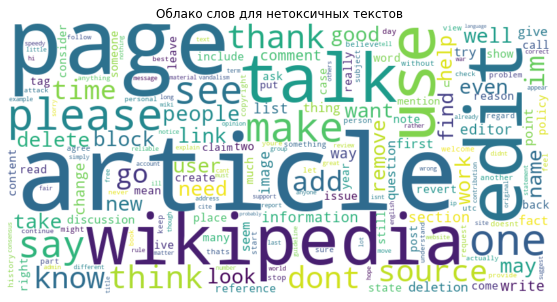

In [7]:
# 4. Облако слов

# Объединение текстов
toxic_texts = ' '.join(data[data['toxic'] == 1]['cleaned_text'])
non_toxic_texts = ' '.join(data[data['toxic'] == 0]['cleaned_text'])

# Генерация облаков слов с отключенными collocations
toxic_wc = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(toxic_texts)
non_toxic_wc = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(non_toxic_texts)

# Визуализация облаков слов
plt.figure(figsize=(10, 5))
plt.imshow(toxic_wc, interpolation='bilinear')
plt.title('Облако слов для токсичных текстов')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(non_toxic_wc, interpolation='bilinear')
plt.title('Облако слов для нетоксичных текстов')
plt.axis('off')
plt.show()

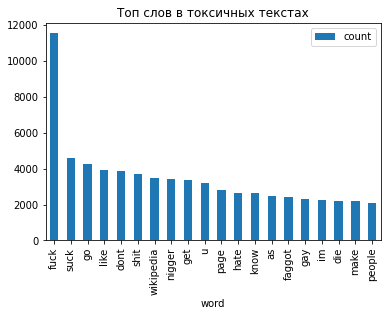

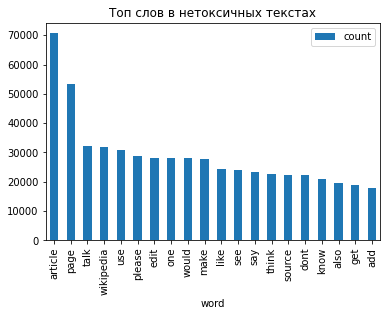

In [8]:
# 5. Частотный анализ слов.В дополнение к облаку слов, можно построить частотные диаграммы:

# Топ слов
toxic_words = Counter(' '.join(data[data['toxic'] == 1]['cleaned_text']).split())
non_toxic_words = Counter(' '.join(data[data['toxic'] == 0]['cleaned_text']).split())

# График
toxic_common = toxic_words.most_common(20)
non_toxic_common = non_toxic_words.most_common(20)

toxic_df = pd.DataFrame(toxic_common, columns=['word', 'count'])
non_toxic_df = pd.DataFrame(non_toxic_common, columns=['word', 'count'])

toxic_df.plot(kind='bar', x='word', y='count', title='Топ слов в токсичных текстах')
plt.show()

non_toxic_df.plot(kind='bar', x='word', y='count', title='Топ слов в нетоксичных текстах')
plt.show()

## Обучение

### Шаг 3: Преобразование текста и построение модели

Используем TfidfVectorizer для преобразования текста, а также обучим модель на основе логистической регрессии или случайного леса.

In [9]:
# Пример данных 
X = data['cleaned_text']
y = data['toxic']  

# Разделение данных на тренировочные и тестовые наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Определение pipeline и параметров для двух моделей


In [10]:
# Для логистической регрессии
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),  # Векторизация текста
    ('classifier', LogisticRegression(random_state=42))  # Логистическая регрессия
])

parameters_lr = {
    'tfidf__max_features': [1000, 5000],
    'classifier__C': [0.1, 1, 10],  # Параметры C для регуляризации
    'classifier__penalty': ['l2'],  # Тип регуляризации
    'classifier__solver': ['liblinear']  # Решатель
}

In [11]:
# Для дерева решений
pipeline_tree = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),  # Векторизация текста
    ('classifier', DecisionTreeClassifier(random_state=42))  # Дерево решений
])

parameters_tree = {
    'tfidf__max_features': [1000, 5000],
    'classifier__max_depth': [5, 10, 20],  # Глубина дерева
    'classifier__min_samples_split': [2, 5, 10],  # Минимум для разбиения
    'classifier__criterion': ['gini', 'entropy']  # Критерии оценки
}

In [12]:
# Настройка GridSearchCV для каждой модели
grid_search_lr = GridSearchCV(
    pipeline_lr,     parameters_lr, 
    cv=5,     n_jobs=-1, 
    verbose=2,     scoring='f1'  # Оптимизируем по обычной F1-мере
)

grid_search_tree = GridSearchCV(
    pipeline_tree, 
    parameters_tree,     
    cv=5, 
    n_jobs=-1, 
    verbose=2, 
    scoring='f1'  # Оптимизируем по обычной F1-мере
)

In [13]:
# Обучение логистической регрессии
print("Обучаем логистическую регрессию...")
grid_search_lr.fit(X_train, y_train)
best_model_lr = grid_search_lr.best_estimator_

# Оценка логистической регрессии через кросс-валидацию
print(f"Лучший результат логистической регрессии на кросс-валидации: {grid_search_lr.best_score_:.4f}")

Обучаем логистическую регрессию...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, tfidf__max_features=1000; total time=   3.8s
[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, tfidf__max_features=1000; total time=   3.9s
[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, tfidf__max_features=1000; total time=   4.1s
[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, tfidf__max_features=1000; total time=   4.1s
[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, tfidf__max_features=1000; total time=   3.9s
[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, tfidf__max_features=5000; total time=   3.9s
[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear, tfidf__max_features=5000; total time=   4.1s
[CV] END classif

In [14]:
# Обучение дерева решений
print("Обучаем дерево решений...")
grid_search_tree.fit(X_train, y_train)
best_model_tree = grid_search_tree.best_estimator_

# Оценка дерева решений через кросс-валидацию
print(f"Лучший результат дерева решений на кросс-валидации: {grid_search_tree.best_score_:.4f}")

Обучаем дерево решений...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_split=2, tfidf__max_features=1000; total time=   4.7s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_split=2, tfidf__max_features=1000; total time=   4.6s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_split=2, tfidf__max_features=1000; total time=   4.5s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_split=2, tfidf__max_features=1000; total time=   4.7s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_split=2, tfidf__max_features=1000; total time=   4.8s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_split=2, tfidf__max_features=5000; total time=   4.9s
[CV] END classifier__criterion=gini, classifier__max_depth=5, classifier

In [15]:
# Выбор лучшей модели по результатам кросс-валидации
if grid_search_lr.best_score_ > grid_search_tree.best_score_:
    final_model = best_model_lr
    print("Лучшая модель: логистическая регрессия")
else:
    final_model = best_model_tree
    print("Лучшая модель: дерево решений")

Лучшая модель: логистическая регрессия


In [16]:
# Финальное тестирование для выбранной модели
y_pred_final = final_model.predict(X_test)
print("Оценка выбранной модели на тестовых данных:")
print(classification_report(y_test, y_pred_final))

# Оценка F1-метрики для финальной модели
f1_final = f1_score(y_test, y_pred_final)
print(f"F1-мера на тестовых данных (финальная модель): {f1_final:.4f}")

Оценка выбранной модели на тестовых данных:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     28658
           1       0.88      0.69      0.77      3201

    accuracy                           0.96     31859
   macro avg       0.92      0.84      0.87     31859
weighted avg       0.96      0.96      0.96     31859

F1-мера на тестовых данных (финальная модель): 0.7713


## Выводы

Лучше всего с данной задачей справляется модель логистической регрессии. 

Подбор гиперпараметров является важным этапом в создании и улучшении модели. Использование GridSearchCV для логистической регрессии позволяет найти оптимальные параметры, такие как 'C', для достижения наилучшей эффективности.

 С моделью, обученной на лучших гиперпараметрах, мы можем получить улучшенную F1-метрику. Если она превысила 0.75, это указывает на хорошую способность модели классифицировать токсичные комментарии.

 Возможности для дальнейшего улучшения модели включают в себя использование более сложных методов обработки текста, таких как эмбеддинги или переход к более продвинутым моделям, таким как BERT, в случае необходимости повышения точности.